<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/06-excitation-transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/06-excitation-transfer.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 6 - Excitation transfer

> TODO: Intro

In [1]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
import gif

import numpy as np
from itertools import product
import pandas as pd
import warnings
import os
from fractions import Fraction
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals

# The helper file below brings functions created in previous tutorials
# make_df_for_energy_scan - we made this in tutorial 4
# make_braket_labels - we made this in tutorial 4
# j_states_list
# 
from libs.helper_06_tutorial import *

## Bringing back the quantised field

> TODO: Hamiltonian

> TODO: Tensor product

In [88]:
def make_operators(num_tss, j, max_bosons):
    
    j_index, jm_list = j_states_list(num_tss)
        
    try:
        j_index[j]
    except:
        raise Exception(f"j needs to be one of {j_vals(num_tss)}")

    
    num_ms = len(m_vals(j)) # number of states in this j universe
    
     # Create the J operator for the number of TSS we have specified
    J = jspin(num_tss)
    
    
    # Now we extract only the states (and labels for those states) for the j we have specified 
    J = [Ji.extract_states(j_index[j]) for Ji in J]  # Loops through the 3 J components and does `extract` for each one
    jm_list = [jm_list[i] for i in j_index[j]]  
    
    # map from QuTiP number states to |n, j, m> states
    possible_ns = range(0, max_bosons+1)
    njm_list = [(n,j,m) for (n,(j,m)) in product(possible_ns, jm_list)]

    
    a        = tensor(destroy(max_bosons+1), qeye(num_ms))     # tensorised boson destruction operator
    number   = tensor(num(max_bosons+1), qeye(num_ms))         # tensorised boson number operator
    Jz       = tensor(qeye(max_bosons+1), J[2])                  # tensorised sigma_x operator 1
    Jx       = tensor(qeye(max_bosons+1), J[0])                  # tensorised sigma_x operator 1
    
    bosons         =   (number+0.5)                                # boson energy operator
    interaction  =    (a.dag() + a) * 2*Jx                        # interaction energy operator
    
    if(num_ms==1):
        interaction.dims = [[max_bosons+1,1],[max_bosons+1,1]]
        
    return Jz, bosons, interaction, number, njm_list

### Energy level landscape $U=0$

We will only look at the $j=1$ universe because we know that the $j=0$ universe is static and unchanging.

In [89]:
Jz, bosons, interaction, number, njm_list = make_operators(2,1,3)

In [90]:
df = make_df_for_energy_scan("$\Delta E$", -4,4, 201, Jz.shape[0])

In [91]:
for i, row in df.iterrows():
    H =  row["$\Delta E$"]*Jz + 1*bosons
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

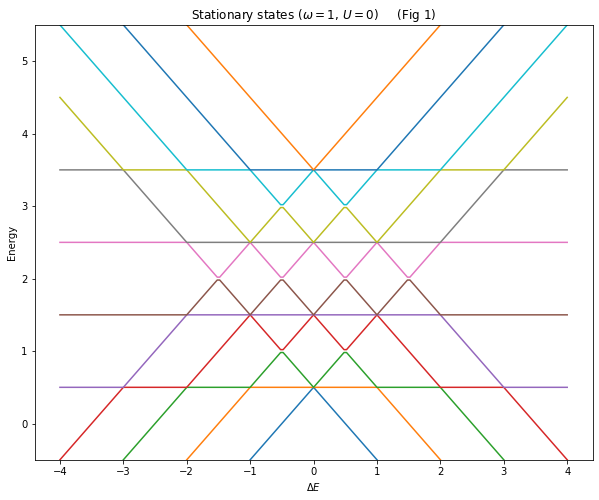

In [92]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=False, 
        title="Stationary states ($\omega=1$, $U=0$)     (Fig 1)");
plt.ylabel("Energy");

### Crossings and anti-crossings


In [93]:
df = make_df_for_energy_scan("$\Delta E$", -4,4, 201, Jz.shape[0])

for i, row in df.iterrows():
    H =  row["$\Delta E$"]*Jz + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

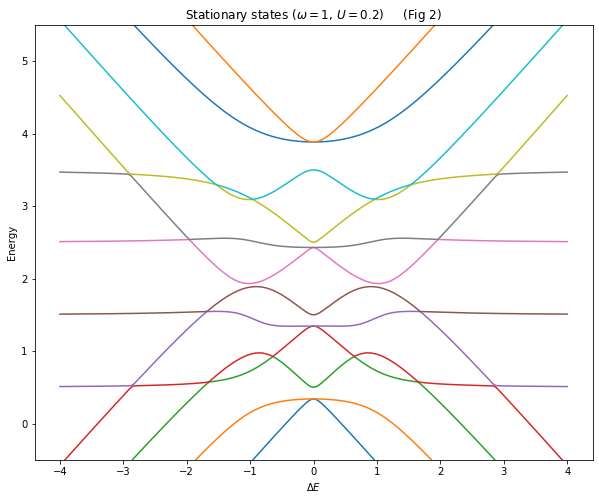

In [94]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=False, 
        title="Stationary states ($\omega=1$, $U=0.2$)     (Fig 2)");
plt.ylabel("Energy");

## Parity

In [170]:
def make_operators(num_tss, j, max_bosons, parity=0):
    
    j_index, jm_list = j_states_list(num_tss)
        
    try:
        j_index[j]
    except:
        raise Exception(f"j needs to be one of {j_vals(num_tss)}")

    
    num_ms = len(m_vals(j)) # number of states in this j universe
    
     # Create the J operator for the number of TSS we have specified
    J = jspin(num_tss)
    
    
    # Now we extract only the states (and labels for those states) for the j we have specified 
    J = [Ji.extract_states(j_index[j]) for Ji in J]  # Loops through the 3 J components and does `extract` for each one
    jm_list = [jm_list[i] for i in j_index[j]]  
    
    # map from QuTiP number states to |n, j, m> states
    possible_ns = range(0, max_bosons+1)
    njm_list = [(n,j,m) for (n,(j,m)) in product(possible_ns, jm_list)]

    
    a        = tensor(destroy(max_bosons+1), qeye(num_ms))     # tensorised boson destruction operator
    number   = tensor(num(max_bosons+1), qeye(num_ms))         # tensorised boson number operator
    Jz       = tensor(qeye(max_bosons+1), J[2])                  # tensorised sigma_x operator 1
    Jx       = tensor(qeye(max_bosons+1), J[0])                  # tensorised sigma_x operator 1
    Jy       = tensor(qeye(max_bosons+1), J[1])                  # tensorised sigma_x operator 1
    J2 = Jx*Jx + Jy*Jy + Jz*Jz
    
    bosons         =   (number+0.5)                                # boson energy operator
    interaction  =    (a.dag() + a) * 2*Jx                        # interaction energy operator
    
    if(num_ms==1):
        interaction.dims = [[max_bosons+1,1],[max_bosons+1,1]]
        
    # PARITY STUFF
    
    M = tensor(qeye(max_bosons+1),qdiags(m_vals(j)[::-1],0))             # M operator
    
    if((2*j)%2==0):
        P = (1j*np.pi*M).expm()*(1j*np.pi*number).expm()                  # parity operator 
    else:
        P = 1j*(1j*np.pi*M).expm()*(1j*np.pi*number).expm() 
    
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        Jz     = Jz.extract_states(p)
        Jx     = Jx.extract_states(p)
        Jy     = Jy.extract_states(p)
        J2     = J2.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction   = interaction.extract_states(p)
        P               = P.extract_states(p)
        njm_list         = [njm_list[i] for i in p]
        
    
        
    return [Jx,Jy,Jz], bosons, interaction, number, njm_list, P, J2

In [178]:
# ODD PARITY

J, bosons, interaction, number, njm_list, P, J2 = make_operators(num_tss=2, j=1, max_bosons=1, parity=-1)

df_odd = make_df_for_energy_scan("$\Delta E$", -4,4, 201, J[2].shape[0])

for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*J[2] + 1*bosons + 0.06*interaction
    evals, ekets = H.eigenstates()
    df_odd.iloc[i,1:] = evals 

In [179]:
# EVEN PARITY

J, bosons, interaction, number, njm_list, P, J2 = make_operators(num_tss=2, j=1, max_bosons=1, parity=1)

df_even = make_df_for_energy_scan("$\Delta E$", -4,4, 201, J[2].shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*J[2] + 1*bosons + 0.06*interaction
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

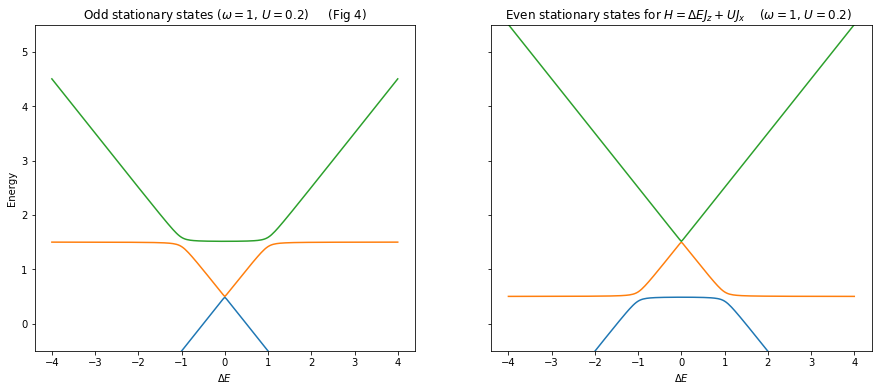

In [180]:
 fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)


df_odd.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Odd stationary states ($\omega=1$, $U=0.2$)     (Fig 4)",  ax=axes[0]);

df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Even stationary states for $H=\Delta E J_{z} + UJ_{x}$    ($\omega=1$, $U=0.2$)  ",  ax=axes[1]);

axes[0].set_ylabel("Energy");

In [181]:
J, bosons, interaction, number, njm_list, P, J2 = make_operators(num_tss=2, j=1, max_bosons=3, parity=1)

df = make_df_for_energy_scan("$\Delta E$", 2.73, 2.8, 201, J[2].shape[0])

for i, row in df.iterrows():
    H =  row["$\Delta E$"]*J[2] + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

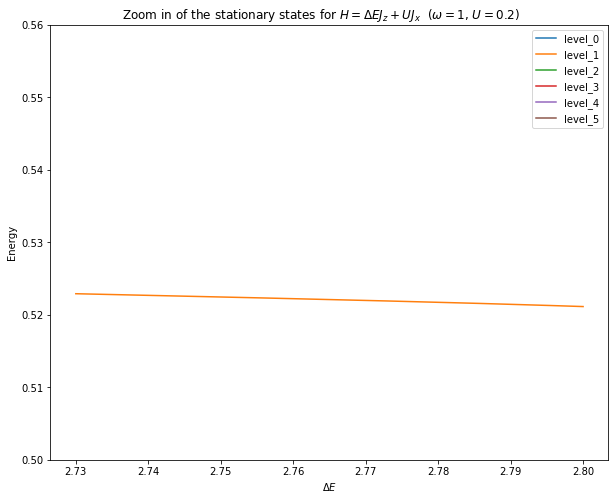

In [182]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[0.5,0.56],legend=True, 
        title="Zoom in of the stationary states for $H=\Delta E J_{z} + UJ_{x}$  ($\omega=1$, $U=0.2$)     ");
plt.ylabel("Energy");



In [118]:
J, bosons, interaction, number, njm_list, P, J2 = make_operators(num_tss=2, j=1, max_bosons=3, parity=1)

In [119]:
njm_list

[(0, 1.0, 0.0),
 (1, 1.0, 1.0),
 (1, 1.0, -1.0),
 (2, 1.0, 0.0),
 (3, 1.0, 1.0),
 (3, 1.0, -1.0)]

In [129]:
psi0 = basis(len(njm_list), 1)

In [130]:
bra_labels, ket_labels = make_braket_labels(njm_list)

In [131]:
#H =  1*J[2] + 1*bosons + 0.05*interaction
H =  2.77*J[2] + 1*bosons + 0.2*interaction

In [132]:
times = np.linspace(0.0, 5000.0, 10000) # simulation time
P, psi = simulate(H, psi0, times)

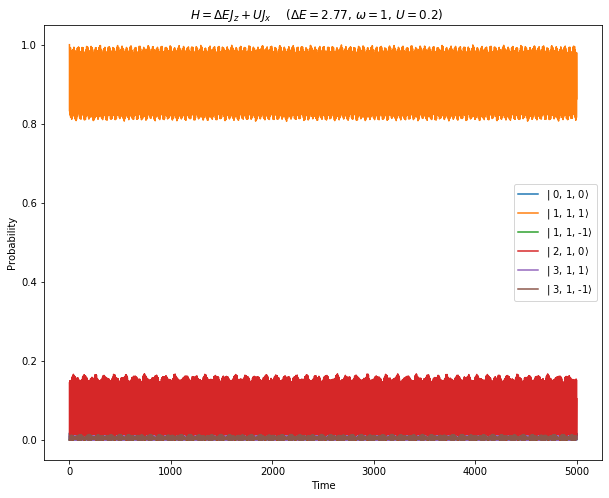

In [133]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("$H=\Delta E J_{z} + UJ_{x}$    ($\Delta E=2.77$, $\omega=1$, $U=0.2$)    ")
plt.show();

## Excitation transfer

In [114]:
J, bosons, interaction, number, njm_list, P, J2 = make_operators(num_tss=2, j=1, max_bosons=4, parity=1)

In [977]:
njm_list

[(0, 1.0, 0.0),
 (1, 1.0, 1.0),
 (1, 1.0, -1.0),
 (2, 1.0, 0.0),
 (3, 1.0, 1.0),
 (3, 1.0, -1.0),
 (4, 1.0, 0.0)]

In [978]:
psi0 = basis(len(njm_list), 0)

In [979]:
bra_labels, ket_labels = make_braket_labels(njm_list)

In [986]:
# H =  2.77*J[2] + 1*bosons + 0.2*interaction
H =  4*J[2] + 1*bosons + 0.2*interaction

In [987]:
evals, ekets = H.eigenstates()

In [988]:
prettify_states(ekets, njm_list)

,0,1,2,3,4,5,6
"(0, 1.0, 0.0)",0.1+0.0j,-0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j,-0.1+0.0j,-0.0+0.0j
"(1, 1.0, 1.0)",-0.0+0.0j,-0.0+0.0j,-0.1+0.0j,0.1+0.0j,0.0+0.0j,-1.0+0.0j,-0.0+0.0j
"(1, 1.0, -1.0)",-1.0+0.0j,0.0+0.0j,0.1+0.0j,-0.1+0.0j,-0.0+0.0j,-0.0+0.0j,-0.0+0.0j
"(2, 1.0, 0.0)",0.1+0.0j,0.2+0.0j,-0.0+0.0j,-1.0+0.0j,-0.0+0.0j,-0.1+0.0j,-0.1+0.0j
"(3, 1.0, 1.0)",-0.0+0.0j,-0.0+0.0j,0.0+0.0j,0.1+0.0j,-0.2+0.0j,0.0+0.0j,-1.0+0.0j
"(3, 1.0, -1.0)",-0.0+0.0j,-1.0+0.0j,-0.0+0.0j,-0.2+0.0j,0.1+0.0j,-0.0+0.0j,-0.0+0.0j
"(4, 1.0, 0.0)",0.0+0.0j,0.1+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j,0.0+0.0j,-0.2+0.0j


(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x182481d470>)

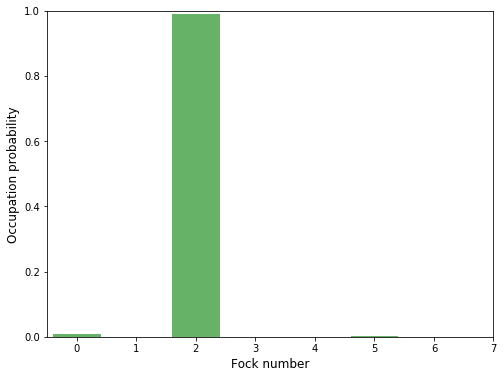

In [989]:
psi0_in_H_basis = psi0.transform(ekets)
plot_fock_distribution(psi0_in_H_basis)

In [990]:
times = np.linspace(0.0, 500.0, 10000) # simulation time
P, psi = simulate(H, psi0, times)

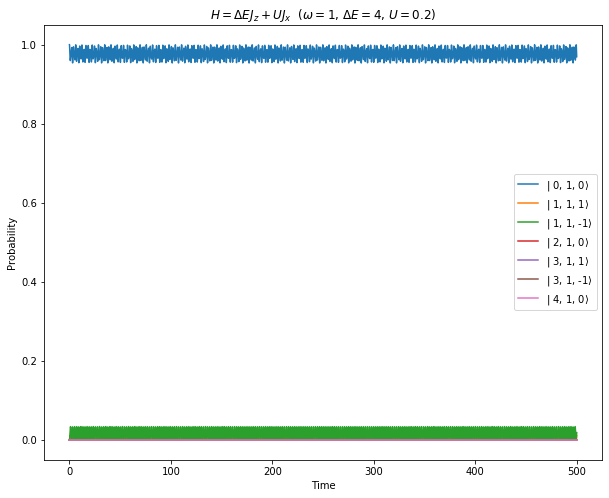

In [997]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("$H=\Delta E J_{z} + UJ_{x}$  ($\omega=1$, $\Delta E=4$, $U=0.2$)")
plt.show();

In [115]:
J = jspin(2, basis="uncoupled")

In [73]:
J2 = J[0]*J[0] + J[1]*J[1] + J[2]*J[2]
J2

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 2.]]

In [76]:
possible_ms = ["+","-"]
mm_list = [mm for mm in product(possible_ms, possible_ms)]
mm_list

[('+', '+'), ('+', '-'), ('-', '+'), ('-', '-')]

In [74]:
evalsJ, eketsJ = J2.eigenstates()

In [77]:
prettify_states(eketsJ, mm_list)

,0,1,2,3
"(+, +)",0.0+0.0j,1.0+0.0j,0.0+0.0j,0.0+0.0j
"(+, -)",0.7+0.0j,0.0+0.0j,0.7+0.0j,0.0+0.0j
"(-, +)",-0.7+0.0j,0.0+0.0j,0.7+0.0j,0.0+0.0j
"(-, -)",0.0+0.0j,0.0+0.0j,0.0+0.0j,1.0+0.0j


In [842]:
basis(4,2).transform(eketsJ)

Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[-0.70710678]
 [ 0.        ]
 [ 0.70710678]
 [ 0.        ]]

---

In [2]:
j_index, jm_list = j_states_list(3)

In [23]:
jm_list

[(1.5, 1.5), (1.5, 0.5), (1.5, -0.5), (1.5, -1.5), (0.5, 0.5), (0.5, -0.5)]

In [6]:
def make_operators(num_tss, max_bosons, j, parity=0):
    
    j_index, jm_list = j_states_list(num_tss)
        
    try:
        j_index[j]
    except:
        raise Exception(f"j needs to be one of {j_vals(num_tss)}")

    
     # Create the J operator for the number of TSS we have specified
    J = jspin(num_tss)
    
    num_ms = len(m_vals(j))
    
    # Now we extract only the states (and labels for those states) for the j we have specified 
    J = [Ji.extract_states(j_index[j]) for Ji in J]  # Loops through the 3 J components and does `extract` for each one
    jm_list = [jm_list[j] for i in j_index[j]]  
    
    
    a        = tensor(destroy(max_bosons+1), qeye(num_ms))     # tensorised boson destruction operator
    number   = tensor(num(max_bosons+1), qeye(num_ms))         # tensorised boson number operator
    Jz       = tensor(qeye(max_bosons+1), J[2])                  # tensorised sigma_x operator 1
    Jx       = tensor(qeye(max_bosons+1), J[0])                  # tensorised sigma_x operator 1
    
    bosons         =   (number+0.5)                                # boson energy operator
    interaction  =    (a.dag() + a) * 2*Jx                        # interaction energy operator
    
    if(num_ms==1):
        interaction.dims = [[max_bosons+1,1],[max_bosons+1,1]]
    
    M = tensor(qeye(max_bosons+1),qdiags(m_vals(j)[::-1],0))    # M operator
    
    if((2*j)%2==0):
        P = (1j*np.pi*M).expm()*(1j*np.pi*number).expm()                  # parity operator 
    else:
        P = 1j*(1j*np.pi*M).expm()*(1j*np.pi*number).expm() 
    
    
    # map from QuTiP number states to |n,J, M> states
    possible_ns = range(0, max_bosons+1)
    njm_list = [(n,j,m) for (n,(j,m)) in product(possible_ns, jm_list)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        Jz     = Jz.extract_states(p)
        Jx     = Jx.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction   = interaction.extract_states(p)
        P               = P.extract_states(p)
        njm_list         = [njm_list[i] for i in p]
    
    
    return Jz, bosons, interaction, number, njm_list, P

In [12]:
Jz, bosons, interaction, number, njm_list, P = make_operators(6, 10, 3, 0)

df = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, Jz.shape[0])

for i, row in df.iterrows():
    H =  row["$\Delta E$"]*Jz + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals 

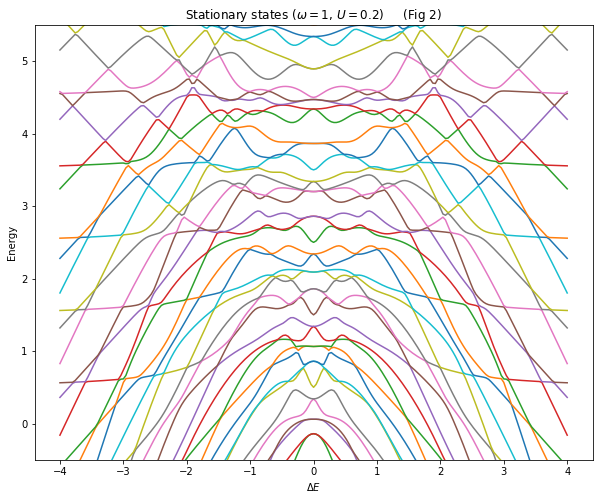

In [8]:
df.plot(x="$\Delta E$",figsize=(10,8),legend=False, ylim=[-0.5,5.5],
        title="Stationary states ($\omega=1$, $U=0.2$)     (Fig 2)");
plt.ylabel("Energy");

In [9]:
## EVEN

Jz, bosons, interaction, number, njm_list, P = make_operators(10, 20, 5, 1)

df_even = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, Jz.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*Jz + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

In [10]:
## ODD

Jz, bosons, interaction, number, njm_list, P = make_operators(10, 20, 5, -1)

df_odd = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, Jz.shape[0])

for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*Jz + 1*bosons + 0.2*interaction
    evals, ekets = H.eigenstates()
    df_odd.iloc[i,1:] = evals 

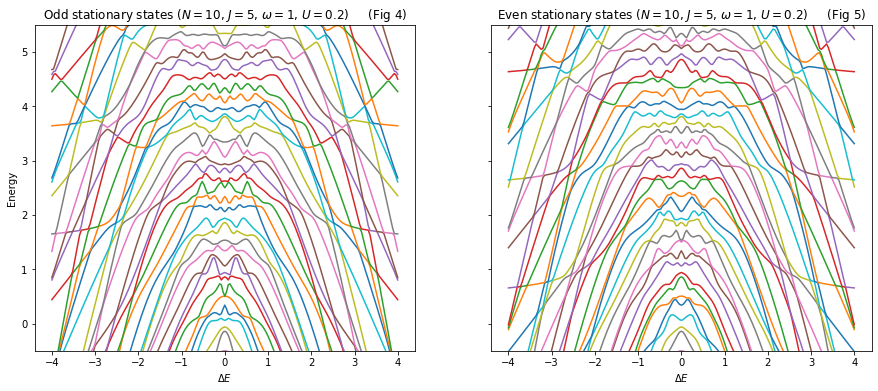

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)


df_odd.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Odd stationary states ($N=10$, $J=5$, $\omega=1$, $U=0.2$)     (Fig 4)",  ax=axes[0]);

df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Even stationary states ($N=10$, $J=5$, $\omega=1$, $U=0.2$)     (Fig 5)",  ax=axes[1]);

axes[0].set_ylabel("Energy");

In [263]:
def make_operators(max_bosons):
    
    a        = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
    number   = tensor(num(max_bosons+1), qeye(2), qeye(2))         # tensorised boson number operator
    sx1      = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised sigma_x operator 1
    sx2      = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised sigma_x operator 2
    sz1      = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))        # tensorised sigma_z operator 1 
    sz2      = tensor(qeye(max_bosons+1), qeye(2), sigmaz())        # tensorised sigma_z operator 2
    sy1      = tensor(qeye(max_bosons+1), sigmay(), qeye(2))       # tensorised sigma_x operator 1
    sy2      = tensor(qeye(max_bosons+1), qeye(2), sigmay())       # tensorised sigma_x operator 2
    
    two_state_1    =    1/2*sz1                                    # two state system energy operator 1
    two_state_2    =    1/2*sz2                                    # two state system energy operator 2
    bosons         =   (number+0.5)                                # boson energy operator
    interaction_1  =    (a.dag() + a) * sx1                        # interaction energy operator 1
    interaction_2  =    (a.dag() + a) * sx2                        # interaction energy operator 2 
    
    # map from QuTiP number states to |n,±, ±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]
    
    
    return two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list

In [264]:
def make_braket_labels(nm_list):
    bra_labels = ["$\langle$"+str(n)+", "+str(m1)+", "+str(m2)+" |" for (n,m1,m2) in nm_list]
    ket_labels = ["| "+str(n)+", "+str(m1)+", "+str(m2)+"$\\rangle$" for (n,m1,m2) in nm_list]
    return bra_labels, ket_labels

In [265]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list = make_operators(
    max_bosons=4)

In [266]:
bra_labels, ket_labels = make_braket_labels(nm_list)

### Energy level landscape $U=0$

Just as in the previous tutorial, let's start with zero coupling to the bosons field to get a sense of the energy level landscape.

In [267]:
df = make_df_for_energy_scan("$\Delta E$", -4,4, 201, two_state_1.shape[0])

In [268]:
for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

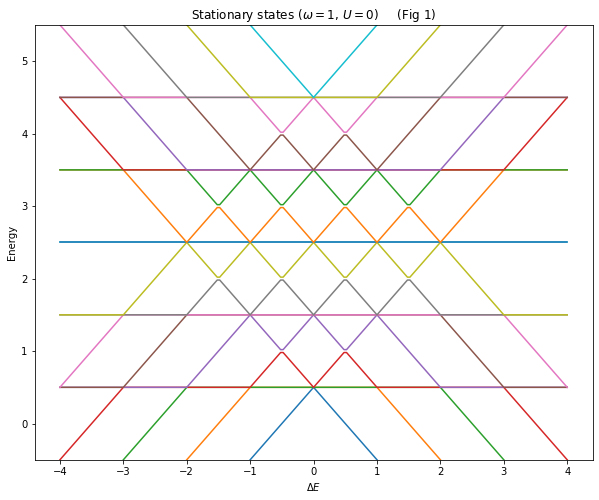

In [269]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=False, 
        title="Stationary states ($\omega=1$, $U=0$)     (Fig 1)");
plt.ylabel("Energy");

>TODO: chat about the levels to give some intuition

Let's see how the energy levels cross and anti-cross when we switch the coupling on

In [270]:
df = make_df_for_energy_scan("$\Delta E$", -4,4, 201, two_state_1.shape[0])

for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.2*interaction_1 + 0.2*interaction_2
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

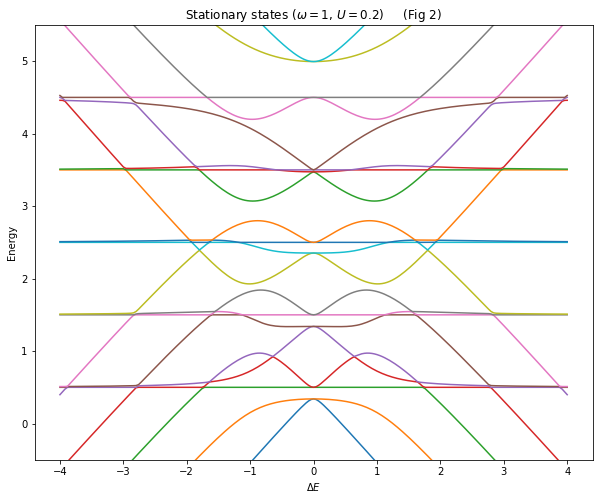

In [271]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=False, 
        title="Stationary states ($\omega=1$, $U=0.2$)     (Fig 2)");
plt.ylabel("Energy");

There are clearly some anti-crossings and also what look like crossings. From what we learnt last time about parity, we can suspect that the crossings correspond to universes that can't interact with each other.

We can make a guess for what parity might be for the cast of 2 TSS. To simplify visuals, we'll reduce the number of bosons.

In [272]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list = make_operators(
    max_bosons=2)

bra_labels, ket_labels = make_braket_labels(nm_list)

In [273]:
sz1 = 2*two_state_1          
sz2 = 2*two_state_2 
parity = sz1*sz2*(1j*np.pi*number).expm()

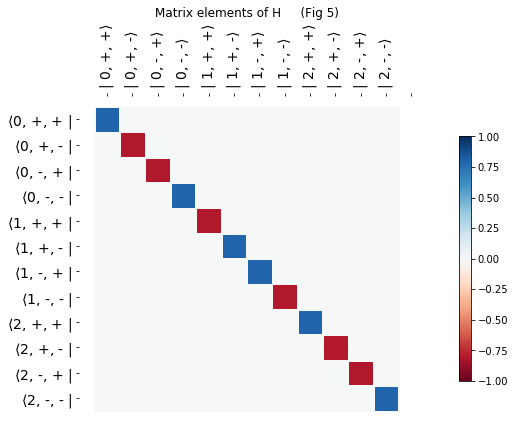

In [274]:
f, ax = hinton(parity, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 3)");

Parity is either 1 or -1 very much like last time.

Taking an example Hamiltonian, we can check whether this "parity" commutes and if it does then it's conserved and we can use it to make out separate universes 

In [275]:
H =  1*two_state_1+ 1*two_state_2 + 1*bosons + 0.2*interaction_1 + 0.2*interaction_2

In [276]:
commutator(H,parity)

Quantum object: dims = [[3, 2, 2], [3, 2, 2]], shape = (12, 12), type = oper, isherm = True
Qobj data =
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

Lovely, we have a good definition of parity.

Let's augment make_operators as we did before.

## Separate parity universes

In [850]:
def make_operators(max_bosons, parity=0):
    
    a        = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
    number   = tensor(num(max_bosons+1), qeye(2), qeye(2))         # tensorised boson number operator
    sx1      = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised sigma_x operator 1
    sx2      = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised sigma_x operator 2
    sz1      = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))        # tensorised sigma_z operator 1 
    sz2      = tensor(qeye(max_bosons+1), qeye(2), sigmaz())        # tensorised sigma_z operator 2
    sy1      = tensor(qeye(max_bosons+1), sigmay(), qeye(2))       # tensorised sigma_x operator 1
    sy2      = tensor(qeye(max_bosons+1), qeye(2), sigmay())       # tensorised sigma_x operator 2
    
    two_state_1    =    1/2*sz1                                    # two state system energy operator 1
    two_state_2    =    1/2*sz2                                    # two state system energy operator 2
    bosons         =   (number+0.5)                                # boson energy operator
    interaction_1  =    (a.dag() + a) * sx1                        # interaction energy operator 1
    interaction_2  =    (a.dag() + a) * sx2                        # interaction energy operator 2 
    
    P = sz1*sz2*(1j*np.pi*number).expm()                           # parity operator 
    
    # map from QuTiP number states to |n,±, ±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        two_state_1     = two_state_1.extract_states(p)
        two_state_2     = two_state_2.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction_1   = interaction_1.extract_states(p)
        interaction_2   = interaction_2.extract_states(p)
        P               = P.extract_states(p)
        nm_list         = [nm_list[i] for i in p]
    
    
    return two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, P

Let's make separate energy level diagrams for even and odd parity

In [851]:
# ODD PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity = make_operators(
    max_bosons=1, parity=-1)

df_odd = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.2*interaction_1 + 0.2*interaction_2
    evals, ekets = H.eigenstates()
    df_odd.iloc[i,1:] = evals 

In [852]:
# EVEN PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity = make_operators(
    max_bosons=1, parity=1)

df_even = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.2*interaction_1 + 0.2*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

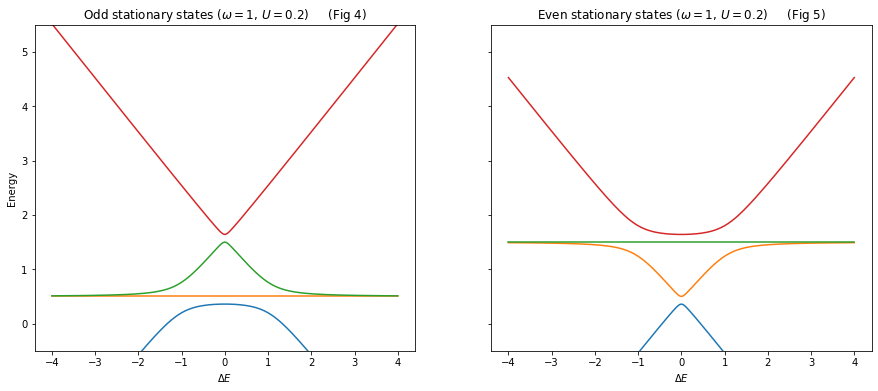

In [853]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)


df_odd.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Odd stationary states ($\omega=1$, $U=0.2$)     (Fig 4)",  ax=axes[0]);

df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Even stationary states ($\omega=1$, $U=0.2$)     (Fig 5)",  ax=axes[1]);

axes[0].set_ylabel("Energy");

What's interesting about these diagrams is that it appears like we might still have some crossings. 

This is because parity isn't the only thing that's conserved - the total spin is as well.

## Total Spin

In [183]:
def make_operators(max_bosons, parity=0):
    
    a        = tensor(destroy(max_bosons+1), qeye(2), qeye(2))     # tensorised boson destruction operator
    number   = tensor(num(max_bosons+1), qeye(2), qeye(2))         # tensorised boson number operator
    sx1      = tensor(qeye(max_bosons+1), sigmax(), qeye(2))       # tensorised sigma_x operator 1
    sx2      = tensor(qeye(max_bosons+1), qeye(2), sigmax())       # tensorised sigma_x operator 2
    sz1      = tensor(qeye(max_bosons+1), sigmaz(), qeye(2))        # tensorised sigma_z operator 1 
    sz2      = tensor(qeye(max_bosons+1), qeye(2), sigmaz())        # tensorised sigma_z operator 2
    sy1      = tensor(qeye(max_bosons+1), sigmay(), qeye(2))       # tensorised sigma_x operator 1
    sy2      = tensor(qeye(max_bosons+1), qeye(2), sigmay())       # tensorised sigma_x operator 2
    
    two_state_1    =    1/2*sz1                                    # two state system energy operator 1
    two_state_2    =    1/2*sz2                                    # two state system energy operator 2
    bosons         =   (number+0.5)                                # boson energy operator
    interaction_1  =    (a.dag() + a) * sx1                        # interaction energy operator 1
    interaction_2  =    (a.dag() + a) * sx2                        # interaction energy operator 2 
    
    P = sz1*sz2*(1j*np.pi*number).expm()                           # parity operator 
    
    S2 = (sx1/2+sx2/2)**2 + (sy1/2+sy2/2)**2 + (sz1/2+sz2/2)**2    # Total "spin"^2 operator
    
    # map from QuTiP number states to |n,±, ±> states
    possible_ns = range(0, max_bosons+1)
    possible_ms = ["+","-"]
    nm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms, possible_ms)]
    
    # only do parity extraction if a valid parity is being used
    if (parity==1) | (parity==-1):
        p           = np.where(P.diag()==parity)[0]
        
        two_state_1     = two_state_1.extract_states(p)
        two_state_2     = two_state_2.extract_states(p)
        bosons          = bosons.extract_states(p)
        number          = number.extract_states(p)
        interaction_1   = interaction_1.extract_states(p)
        interaction_2   = interaction_2.extract_states(p)
        S2              = S2.extract_states(p)
        P               = P.extract_states(p)
        nm_list         = [nm_list[i] for i in p]
    
    
    return two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, P, S2

In [857]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity, S2 = make_operators(
    max_bosons=1, parity=-1)


spin = S2.eigenstates()[1]
p   = np.where(S2.eigenenergies()==2)[0]


df_odd = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, p.shape[0])
# df_odd = make_df_for_energy_scan("$\Delta E$", 2.75,2.8, 201, p.shape[0])


for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.2*interaction_1 + 0.2*interaction_2
    test = H.transform(S2.eigenstates()[1])
    test = test.extract_states(p)
    evals, ekets = test.eigenstates()
    df_odd.iloc[i,1:] = evals 

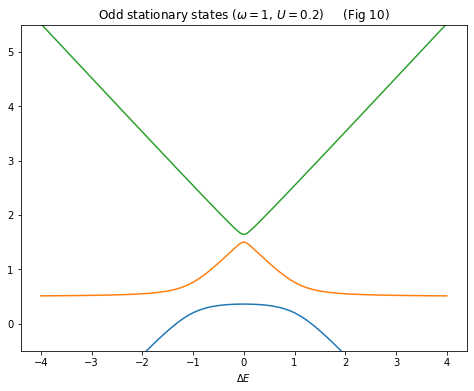

In [858]:
df_odd.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False,  figsize=(8,6),
        title="Odd stationary states ($\omega=1$, $U=0.2$)     (Fig 10)");

In [859]:
ekets

array([Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.09335356]
 [-0.00328964]
 [-0.99562759]],
       Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[ 0.99403368]
 [-0.05634982]
 [ 0.0933903 ]],
       Quantum object: dims = [[3], [1]], shape = (3, 1), type = ket
Qobj data =
[[-0.05641065]
 [-0.99840567]
 [-0.00199044]]], dtype=object)

In [860]:
evals

array([-2.52652033,  0.51053951,  5.51598082])

In [206]:
H = 1*two_state_1+ 1*two_state_2 + 1*bosons

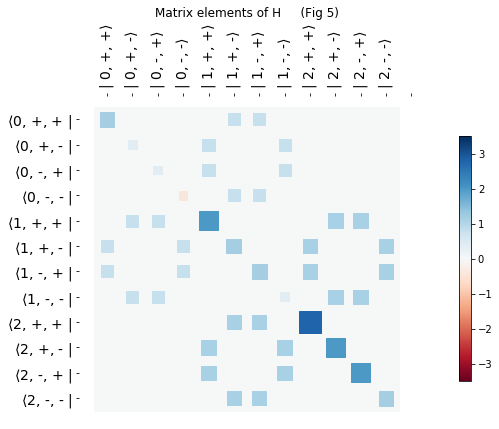

In [178]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 5)");

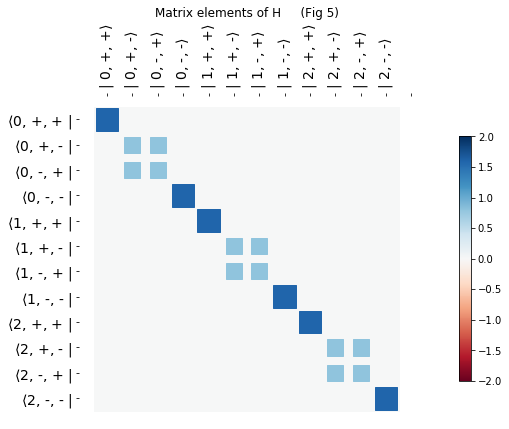

In [179]:
f, ax = hinton(S2, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 5)");

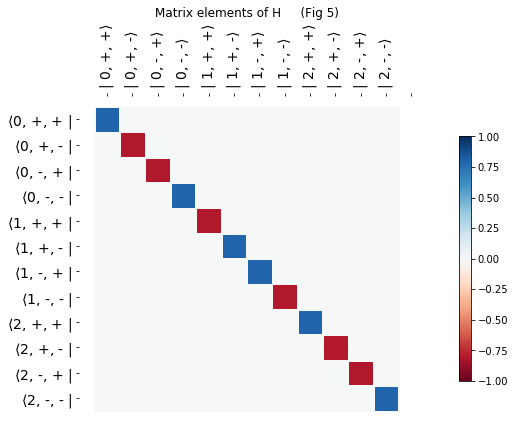

In [180]:
f, ax = hinton(parity, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90,)
ax.set_title("Matrix elements of H     (Fig 5)");

In [72]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity, S2 = make_operators(
    max_bosons=1, parity=-1)

In [73]:
H = 3*two_state_1+ 3*two_state_2 + 1*bosons + 0.2*interaction_1 + 0.2*interaction_2

In [74]:
H

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[ 0.5  0.   0.2  0.2]
 [ 0.   0.5  0.2  0.2]
 [ 0.2  0.2  4.5  0. ]
 [ 0.2  0.2  0.  -1.5]]

In [75]:
evals, ekets = H.eigenstates()

In [87]:
nm_list

[(0, '+', '-'), (0, '-', '+'), (1, '+', '+'), (1, '-', '-')]

In [77]:
evals

array([-1.53948208,  0.5       ,  0.51951541,  4.51996667])

In [78]:
ekets

array([Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[-0.09775531]
 [-0.09775531]
 [ 0.00647442]
 [ 0.99037664]],
       Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[ 0.70710678]
 [-0.70710678]
 [ 0.        ]
 [ 0.        ]],
       Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[-0.69854464]
 [-0.69854464]
 [ 0.07019694]
 [-0.13835886]],
       Quantum object: dims = [[4], [1]], shape = (4, 1), type = ket
Qobj data =
[[-0.04979248]
 [-0.04979248]
 [-0.99751214]
 [-0.00330849]]], dtype=object)

In [79]:
nm_list


[(0, '+', '-'), (0, '-', '+'), (1, '+', '+'), (1, '-', '-')]

In [80]:
psi0 = basis(len(nm_list), 0)

(<Figure size 576x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1102dcdd8>)

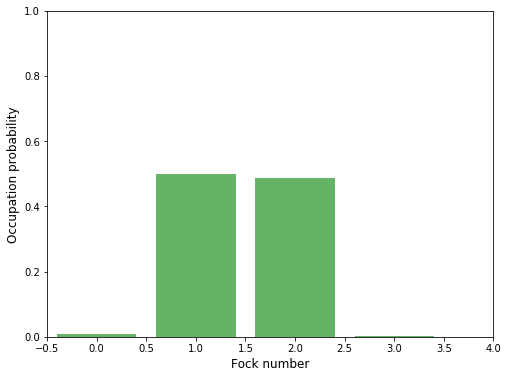

In [81]:
psi0_in_H_basis = psi0.transform(ekets)
plot_fock_distribution(psi0_in_H_basis)

In [82]:
bra_labels, ket_labels = make_braket_labels(nm_list)

In [83]:
nm_list

[(0, '+', '-'), (0, '-', '+'), (1, '+', '+'), (1, '-', '-')]

In [84]:
test

NameError: name 'test' is not defined

In [85]:
times = np.linspace(0.0, 500.0, 10000) # simulation time
P, psi = simulate(H, basis(H.shape[0], 1), times)

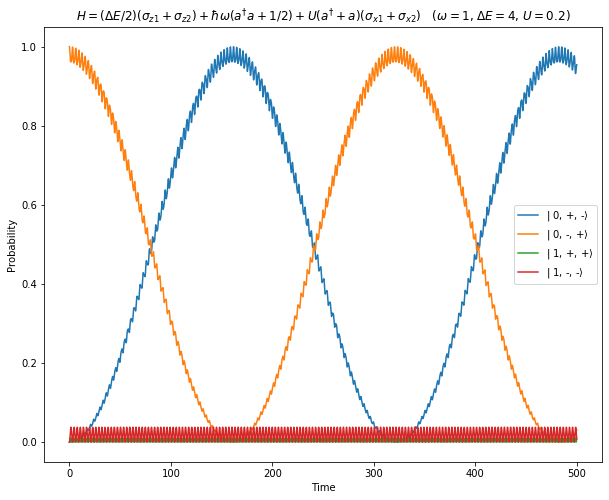

In [86]:
plt.figure(figsize=(10,8))
for i in range(0,P.shape[0]):
    plt.plot(times, P[i,:], label=f"{ket_labels[i]}")
plt.ylabel("Probability")
plt.xlabel("Time")
plt.legend(loc="right")
plt.title("$H = (\Delta E / 2) (\sigma_{z1} + \sigma_{z2}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )(\sigma_{x1} +\sigma_{x2} )$   ($\omega=1$, $\Delta E = 4$, $U=0.2$)")
plt.show();

In [196]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity, S2 = make_operators(max_bosons=2)

In [197]:
bra_labels, ket_labels = make_braket_labels(nm_list)

In [198]:
df = make_df_for_energy_scan("$\Delta E$", -4,4, 201, two_state_1.shape[0])

In [199]:
for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.001*interaction_1 + 0.001*interaction_2
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

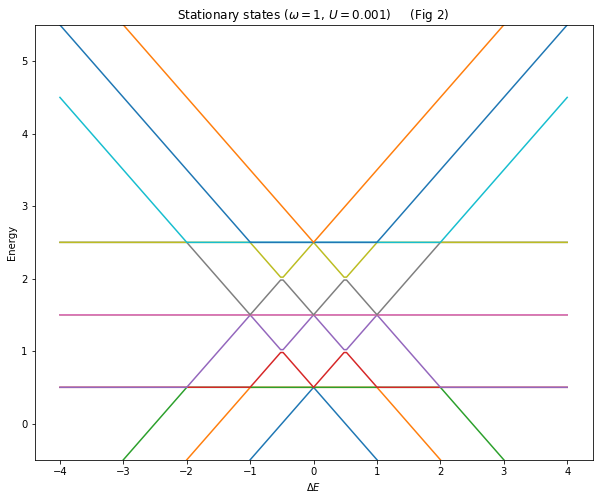

In [200]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=False, 
        title="Stationary states ($\omega=1$, $U=0.001$)     (Fig 2)");
plt.ylabel("Energy");

In [201]:
df = make_df_for_energy_scan("$\Delta E$", 2,4, 201, two_state_1.shape[0])
for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.001*interaction_1 + 0.001*interaction_2
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

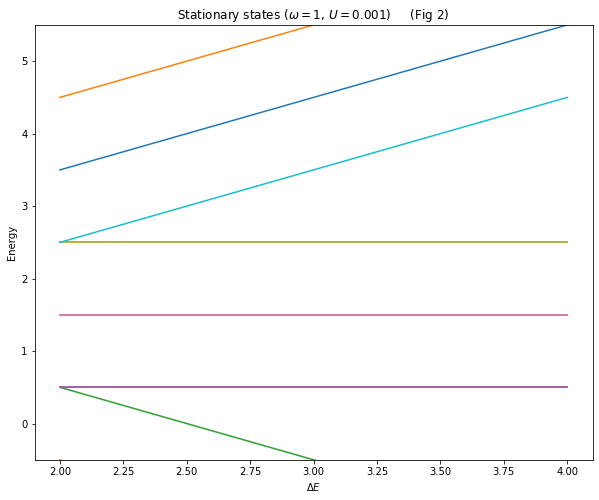

In [202]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=False, 
        title="Stationary states ($\omega=1$, $U=0.001$)     (Fig 2)");
plt.ylabel("Energy");

In [203]:
df = make_df_for_energy_scan("$\Delta E$", -4,4, 201, two_state_1.shape[0])
for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.06*interaction_1 + 0.06*interaction_2
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

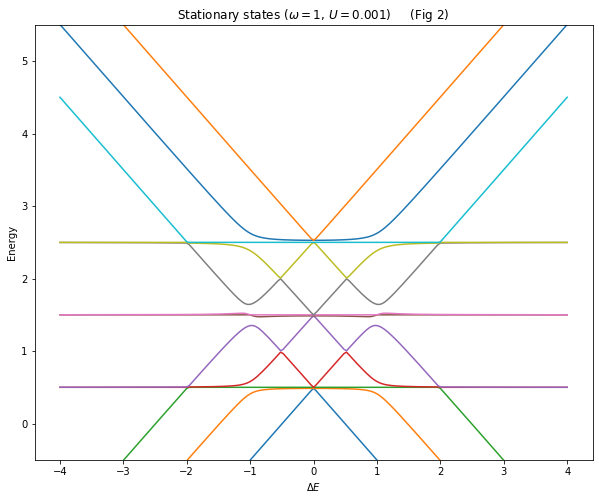

In [204]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[-0.5,5.5],legend=False, 
        title="Stationary states ($\omega=1$, $U=0.001$)     (Fig 2)");
plt.ylabel("Energy");

In [205]:
df = make_df_for_energy_scan("$\Delta E$", 2.75,2.8, 201, two_state_1.shape[0])
for i, row in df.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.2*interaction_1 + 0.2*interaction_2
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals

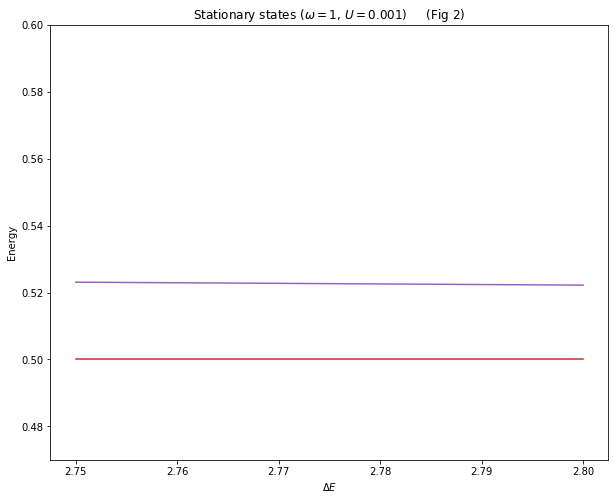

In [206]:
df.plot(x="$\Delta E$",figsize=(10,8),ylim=[0.47,0.6],legend=False, 
        title="Stationary states ($\omega=1$, $U=0.001$)     (Fig 2)");
plt.ylabel("Energy");

In [207]:
# ODD PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity, S2 = make_operators(max_bosons=4, parity=-1)

df_odd = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.001*interaction_1 + 0.001*interaction_2
    evals, ekets = H.eigenstates()
    df_odd.iloc[i,1:] = evals 

In [208]:
# EVEN PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity, S2 = make_operators(max_bosons=4, parity=1)

df_even = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.001*interaction_1 + 0.001*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

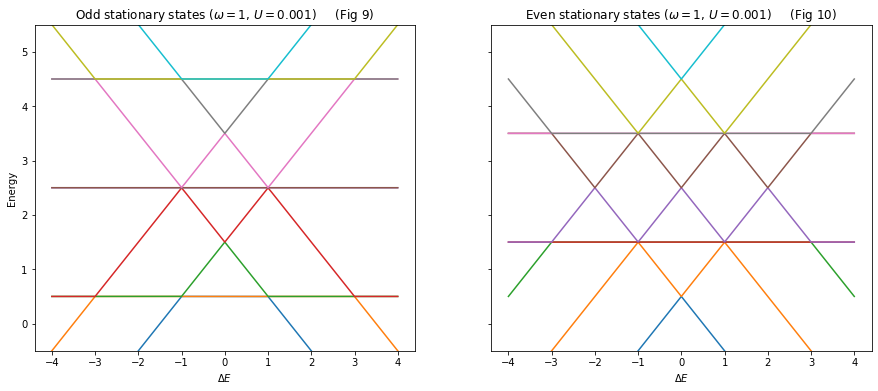

In [209]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)


df_odd.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Odd stationary states ($\omega=1$, $U=0.001$)     (Fig 9)",  ax=axes[0]);

df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Even stationary states ($\omega=1$, $U=0.001$)     (Fig 10)",  ax=axes[1]);

axes[0].set_ylabel("Energy");

In [210]:
# ODD PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity, S2 = make_operators(max_bosons=4, parity=-1)

df_odd = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2
    evals, ekets = H.eigenstates()
    df_odd.iloc[i,1:] = evals 

In [211]:
# EVEN PARITY

two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity, S2 = make_operators(max_bosons=4, parity=1)

df_even = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, two_state_1.shape[0])

for i, row in df_even.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.1*interaction_1 + 0.1*interaction_2
    evals, ekets = H.eigenstates()
    df_even.iloc[i,1:] = evals 

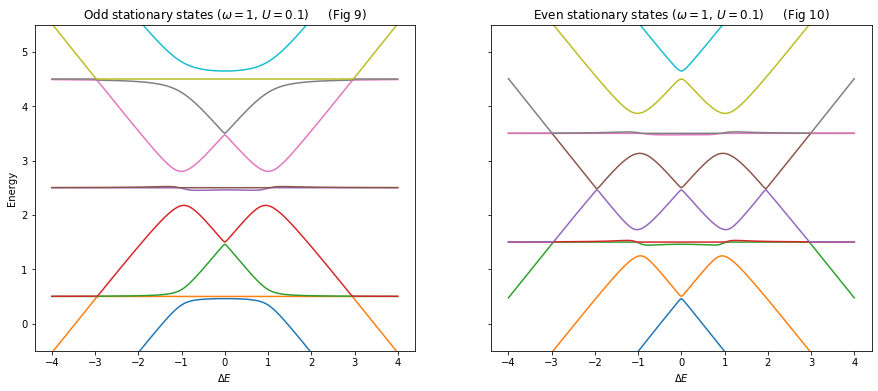

In [212]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6), sharey=True)


df_odd.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Odd stationary states ($\omega=1$, $U=0.1$)     (Fig 9)",  ax=axes[0]);

df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False, 
        title="Even stationary states ($\omega=1$, $U=0.1$)     (Fig 10)",  ax=axes[1]);

axes[0].set_ylabel("Energy");

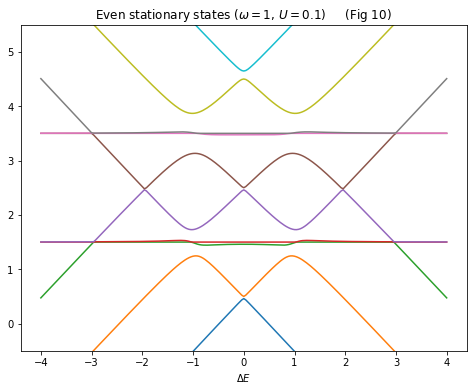

In [213]:
df_even.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False,  figsize=(8,6),
        title="Even stationary states ($\omega=1$, $U=0.1$)     (Fig 10)");

In [155]:
two_state_1, two_state_2, bosons, interaction_1, interaction_2, number, nm_list, parity, S2 = make_operators(max_bosons=4, parity=-1)


spin = S2.eigenstates()[1]
p   = np.where(S2.eigenenergies()==2)[0]


df_odd = make_df_for_energy_scan("$\Delta E$", -4, 4, 201, p.shape[0])
# df_odd = make_df_for_energy_scan("$\Delta E$", 2.75,2.8, 201, p.shape[0])





for i, row in df_odd.iterrows():
    H =  row["$\Delta E$"]*two_state_1+ row["$\Delta E$"]*two_state_2 + 1*bosons + 0.001*interaction_1 + 0.001*interaction_2
    test = H.transform(S2.eigenstates()[1])
    test = test.extract_states(p)
    evals, ekets = test.eigenstates()
    df_odd.iloc[i,1:] = evals 

In [156]:
nm_list

[(0, '+', '-'),
 (0, '-', '+'),
 (1, '+', '+'),
 (1, '-', '-'),
 (2, '+', '-'),
 (2, '-', '+'),
 (3, '+', '+'),
 (3, '-', '-'),
 (4, '+', '-'),
 (4, '-', '+')]

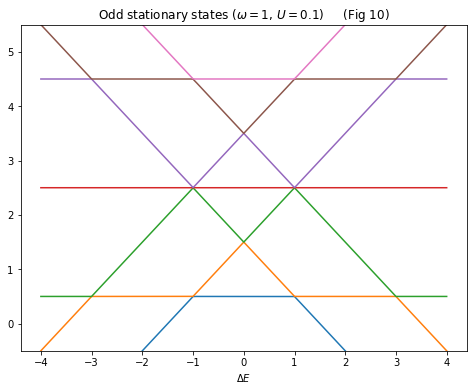

In [78]:
df_odd.plot(x="$\Delta E$",ylim=[-0.5,5.5],legend=False,  figsize=(8,6),
        title="Odd stationary states ($\omega=1$, $U=0.1$)     (Fig 10)");

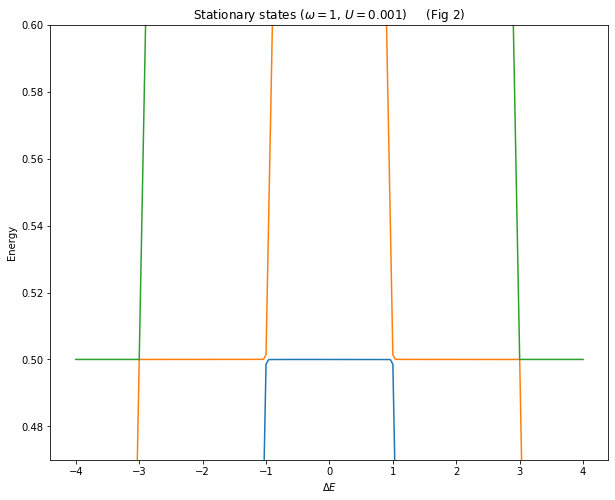

In [77]:
df_odd.plot(x="$\Delta E$",figsize=(10,8),ylim=[0.47,0.6],legend=False, 
        title="Stationary states ($\omega=1$, $U=0.001$)     (Fig 2)");
plt.ylabel("Energy");

>TODO: Need to look at 

https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf - addition of angular momentum

https://en.wikipedia.org/wiki/Clebsch%E2%80%93Gordan_coefficients

http://www.lassp.cornell.edu/clh/p654/MM-Lec0.pdf

https://quantummechanics.ucsd.edu/ph130a/130_notes/node312.html

In [38]:
sigmax()**2+sigmay()**2+sigmaz()**2

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[3. 0.]
 [0. 3.]]

In [82]:
sx1 = tensor(sigmax()/2, qeye(2))
sy1 = tensor(sigmay()/2, qeye(2))
sz1 = tensor(sigmaz()/2, qeye(2))

In [83]:
sx2 = tensor(qeye(2), sigmax()/2)
sy2 = tensor(qeye(2), sigmay()/2)
sz2 = tensor(qeye(2), sigmaz()/2)

In [84]:
S2 = (sx1+sx2)**2 + (sy1+sy2)**2 + (sz1+sz2)**2

(<Figure size 576x432 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18264c32e8>)

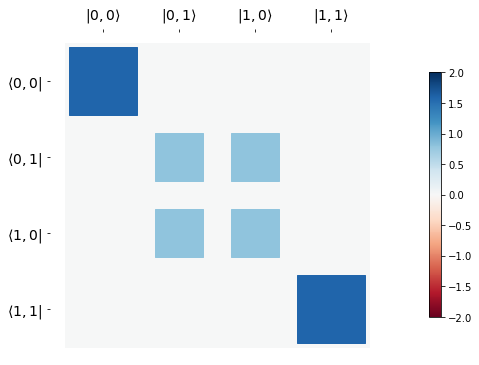

In [85]:
hinton(S2)

In [86]:
S2

Quantum object: dims = [[2, 2], [2, 2]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[2. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 2.]]

In [87]:
S2.eigenstates()

(array([1.11022302e-15, 2.00000000e+00, 2.00000000e+00, 2.00000000e+00]),
 array([Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[ 0.        ]
  [ 0.70710678]
  [-0.70710678]
  [ 0.        ]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[1.]
  [0.]
  [0.]
  [0.]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.        ]
  [0.70710678]
  [0.70710678]
  [0.        ]],
        Quantum object: dims = [[2, 2], [1, 1]], shape = (4, 1), type = ket
 Qobj data =
 [[0.]
  [0.]
  [0.]
  [1.]]], dtype=object))

---

In [167]:
A = 0.1

df = make_df_for_energy_scan("$\Delta E$", -8, 8, 201, 2)

for i, row in df.iterrows():
    H =  2*A*A/( row["$\Delta E$"]*row["$\Delta E$"] - 1 )*sigmax()
    evals, ekets = H.eigenstates()
    df.iloc[i,1:] = evals 

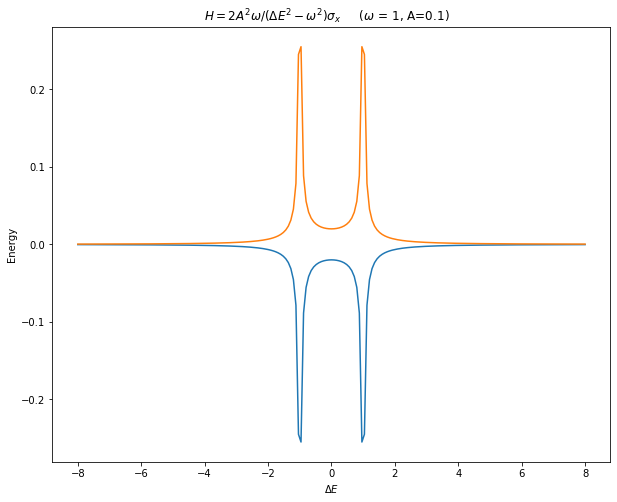

In [169]:
df.plot(x="$\Delta E$",figsize=(10,8),legend=False, 
        title="$H = 2A^2 \omega/(\Delta E ^2 - \omega^2)\sigma_{x}$     ($\omega$ = 1, A=0.1)   ");
plt.ylabel("Energy");